In [112]:
import json
ate_train  = json.load(open('/kaggle/input/json-data-ate/ATE_train.json'))
ate_test = json.load(open('/kaggle/input/json-data-ate/ATE_test.json'))
ate_val = json.load(open('/kaggle/input/json-data-ate/ATE_val.json'))
# ate_train_csv = {}
# ate_test_csv = {}
sentence = []
Tag = []
Words = []
count = 0
for i in ate_train:

    for j in ate_train[i]['label']:
        sentence.append(str(count))
        Tag.append(j)
    for j in ate_train[i]['text']:
        Words.append(j)
    count+=1
ate_train_csv = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(ate_train_csv)
df.to_csv('ate_train.csv',index=False)

sentence = []
Tag = []
Words = []
count = 0
for i in ate_test:

    for j in ate_test[i]['label']:
        sentence.append(str(count))
        Tag.append(j)
    for j in ate_test[i]['text']:
        Words.append(j)
    count+=1
ate_test_csv = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(ate_test_csv)
df.to_csv('ate_test.csv',index=False)

sentence = []
Tag = []
Words = []
count = 0
for i in ate_val:

    for j in ate_val[i]['label']:
        sentence.append(str(count))
        Tag.append(j)
    for j in ate_val[i]['text']:
        Words.append(j)
    count+=1
ate_val_csv = {"Sentence #":sentence,"Word":Words,"Tag":Tag}
print(len(sentence),len(Words),len(Tag))
# save this as csv file
df = pd.DataFrame(ate_val_csv)
df.to_csv('ate_val.csv',index=False)

17354 17354 17354
5171 5171 5171
4175 4175 4175


In [113]:
import pandas as pd
import numpy as np
import re
import string

# data = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv", encoding="latin1")

# data = pd.read_csv("/kaggle/input/dsets-t3/train.csv")
# test_data = pd.read_csv("/kaggle/input/dsets-t3/test.csv")
test_data = pd.read_csv("/kaggle/working/ate_test.csv")
data = pd.read_csv("/kaggle/working/ate_train.csv")
val_data = pd.read_csv("/kaggle/working/ate_val.csv")
# print(len(data))
words = []


In [114]:
# print(data.head())
words = []
count = 0
def remove_punct(word):
    pun = list(".,()-:;?!")
    try:
        for i in pun:
            if i in word:
#                 print(i)
                word = word.replace(i,"")
    except:
        word = word
#     print(word)
    return word       
for i in data['Word']:
    words.append(remove_punct(i))

In [115]:
print(len(words),len(data))
data['Word'] = words

17354 17354


In [116]:
data['Tag'].value_counts()



O    15489
B     1281
I      584
Name: Tag, dtype: int64

In [117]:
# data.head(1)

In [118]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences
print(len(test_sentences),len(sentences))

val_getter = SentenceGetter(val_data)
val_sentences = test_getter.sentences

328 906


In [119]:
from math import nan
# temp_data = data+test_data
words = list(set(data["Word"].values))
test_words = list(set(test_data['Word'].values))
words = set(words+test_words)
n_words = len(words)

tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)




## Prepare the data
Now we introduce dictionaries of words and tags.

In [120]:
from future.utils import iteritems


word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i:w for w, i in word2idx.items()}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}


In [121]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y_train = [to_categorical(i, num_classes=n_tags) for i in y]
X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
print(len(X_test))
X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1) 

y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]
print(len(y_test))
y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]
print(len(y_test))


X_val = [[word2idx[w[0]] for w in s] for s in val_sentences]
print(len(X_val))
X_val = pad_sequences(maxlen=maxlen, sequences=X_val, padding="post",value=n_words - 1) 

y_val = [[tag2idx[w[1]] for w in s] for s in val_sentences]
print(len(y_val))
y_val = pad_sequences(maxlen=maxlen, sequences=y_val, padding="post", value=tag2idx["O"])
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
print(len(y_test))
# Split train and test data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# X_train = data['Word']
# y_train = data['Tag']

# X_test = test_data['Word']
# y_test = test_data['Tag']

print(len(X_test),len(X_train))

328
328
328
328
328
328
328 906


## Setup the CRF-BILSTM



In [45]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
! pip install sklearn_crfsuite


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qhmx1j9b
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qhmx1j9b
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=054d1f5b4777b69660b5b3e3f121a1a24a29fab8025ae412021c0b4e71dbe416
  Stored in directory: /tmp/pip-ephem-wheel-cache-cl1mbgg4/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [123]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

In [124]:
print(k.__version__)


2.3.1


## F1 MACRO

In [125]:
from tensorflow.keras.callbacks import Callback
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import f1_score

def F1_Score(y_test,y_pred):
    y_test = np.argmax(y_test, axis=2)
    # Flatten y_pred if necessary
    if y_pred.ndim == 3:
        y_pred = np.argmax(y_pred, axis=2)
    classes = np.unique(y_test)
    precision = []
    recall = []
    f1 = []
    for c in classes:
        tp = np.sum((y_test == c) & (y_pred == c))
        fp = np.sum((y_test != c) & (y_pred == c))
        fn = np.sum((y_test == c) & (y_pred != c))
        
        precision_c = tp / (tp + fp) if tp + fp > 0 else 0
        recall_c = tp / (tp + fn) if tp + fn > 0 else 0
        f1_c = 2 * (precision_c * recall_c) / (precision_c + recall_c) if precision_c + recall_c > 0 else 0
        
        precision.append(precision_c)
        recall.append(recall_c)
        f1.append(f1_c)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    return macro_f1

class F1ScoreCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs={}):
        # Predict on training and validation sets
        y_train_pred = np.argmax(self.model.predict(self.X_train), axis=-1)
        y_val_pred = np.argmax(self.model.predict(self.X_val), axis=-1)

        # Calculate F1 scores for training and validation sets
        f1_train = F1_Score(self.y_train, y_train_pred)
        f1_val = F1_Score(self.y_val, y_val_pred)



#         print(f' - F1 Score (train): {f1_train:.4f}')
#         print(f' - F1 Score (val): {f1_val:.4f}')

#         # Log F1 scores to the logs dictionary (for logging with Keras)
        if logs is not None:
            logs['f1_score_train'] = f1_train
            logs['f1_score_val'] = f1_val

        # Print F1 scores
        print(f' - f1_train: {f1_train:.4f} - f1_val: {f1_val:.4f}')
f1_callback = F1ScoreCallback(X_train, np.array(y_train), X_val, np.array(y_val))

## GLOVE

In [126]:
input = Input(shape=(1,))
word_embedding_size = 10

embedding_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_dim = 100
def load_glove_embeddings(embedding_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(embedding_path, encoding='utf-8') as f:
        print(f)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(embedding_path, embedding_dim, word2idx)





<_io.TextIOWrapper name='/kaggle/input/glove6b100dtxt/glove.6B.100d.txt' mode='r' encoding='utf-8'>


In [127]:
from keras.models import Model, Input,Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
m = 78
# m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=100, input_length=m, weights=[embedding_matrix]))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf = CRF(n_tags)
model.add(crf)

In [128]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 78, 100)           318200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 78, 200)           160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 78, 3)             603       
_________________________________________________________________
crf_3 (CRF)                  (None, 78, 3)             27        
Total params: 479,630
Trainable params: 479,630
Non-trainable params: 0
_________________________________________________________________


In [129]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.05, beta_1=0.2, beta_2=0.1)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
joblib.dump(model, "glove_ate_3_a.pkl")

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 815 samples, validate on 91 samples
Epoch 1/10
815/815 [==============================] - 3s 3ms/step - loss: 0.3749 - crf_viterbi_accuracy: 0.7345 - accuracy: 0.9737 - val_loss: 0.1317 - val_crf_viterbi_accuracy: 0.9725 - val_accuracy: 0.9725
 - f1_train: 0.3289 - f1_val: 0.3287
Epoch 2/10
815/815 [==============================] - 1s 956us/step - loss: 0.1349 - crf_viterbi_accuracy: 0.9663 - accuracy: 0.9737 - val_loss: 0.0784 - val_crf_viterbi_accuracy: 0.9737 - val_accuracy: 0.9737
 - f1_train: 0.3896 - f1_val: 0.3651
Epoch 3/10
815/815 [==============================] - 1s 967us/step - loss: 0.0566 - crf_viterbi_accuracy: 0.9795 - accuracy: 0.9737 - val_loss: 0.0637 - val_crf_viterbi_accuracy: 0.9818 - val_accuracy: 0.9818
 - f1_train: 0.8013 - f1_val: 0.6752
Epoch 4/10
815/815 [==============================] - 1s 1ms/step - loss: 0.0331 - crf_viterbi_accuracy: 0.9891 - accuracy: 0.9737 - val_loss: 0.0709 - val_crf_viterbi_accuracy: 0.9799 - val_accuracy: 0.9799
 - f1_tr

['glove_ate_3_a.pkl']

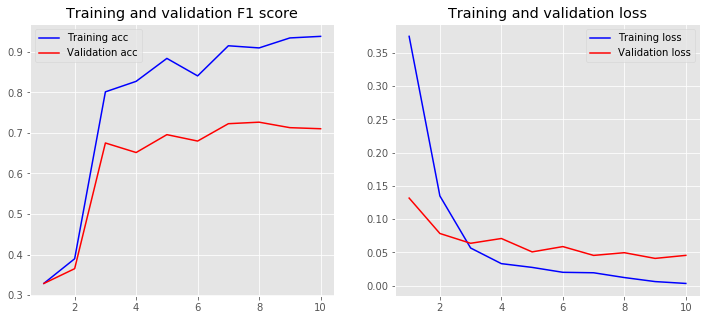

In [130]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [131]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

328
328/328 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           B       0.74      0.64      0.69       463
           I       0.39      0.55      0.45       243
           O       0.99      0.99      0.99     24878

    accuracy                           0.98     25584
   macro avg       0.71      0.72      0.71     25584
weighted avg       0.98      0.98      0.98     25584



In [ ]:
# ! pip install seqeval


## WORD2VEC


In [132]:
from gensim.models import KeyedVectors
from tqdm import tqdm
input = Input(shape=(76,))
word_embedding_size = 150
embedding_dim = 300
print("here")
word2vec_path = "/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"  # Replace this with the path to your Word2Vec model

def load_word2vec_embeddings(word2vec_path, embedding_dim, word_index):
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
    print("loading done")
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in tqdm(word_index.items()):
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]

    return embedding_matrix

embedding_matrix = load_word2vec_embeddings(word2vec_path, embedding_dim, word2idx)

here


100%|██████████| 3181/3181 [00:00<00:00, 135831.83it/s]

loading done


In [134]:
m = 78
# m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=300, input_length=m, weights=[embedding_matrix]))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf_layer = CRF(n_tags)
model.add(crf_layer)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.05, beta_1=0.2, beta_2=0.1)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
joblib.dump(model, "word2vec_ate_3.pkl")

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 815 samples, validate on 91 samples
Epoch 1/10
815/815 [==============================] - 3s 3ms/step - loss: 0.4442 - crf_viterbi_accuracy: 0.7287 - accuracy: 0.9737 - val_loss: 0.1373 - val_crf_viterbi_accuracy: 0.9682 - val_accuracy: 0.9682
 - f1_train: 0.3559 - f1_val: 0.3396
Epoch 2/10
815/815 [==============================] - 1s 1ms/step - loss: 0.1018 - crf_viterbi_accuracy: 0.9728 - accuracy: 0.9737 - val_loss: 0.0560 - val_crf_viterbi_accuracy: 0.9834 - val_accuracy: 0.9834
 - f1_train: 0.7959 - f1_val: 0.6676
Epoch 3/10
815/815 [==============================] - 1s 969us/step - loss: 0.0400 - crf_viterbi_accuracy: 0.9879 - accuracy: 0.9737 - val_loss: 0.0513 - val_crf_viterbi_accuracy: 0.9849 - val_accuracy: 0.9849
 - f1_train: 0.8830 - f1_val: 0.7234
Epoch 4/10
815/815 [==============================] - 1s 965us/step - loss: 0.0307 - crf_viterbi_accuracy: 0.9906 - accuracy: 0.9737 - val_loss: 0.0543 - val_crf_viterbi_accuracy: 0.9838 - val_accuracy: 0.9838
 - f1_tr

['word2vec_ate_3.pkl']

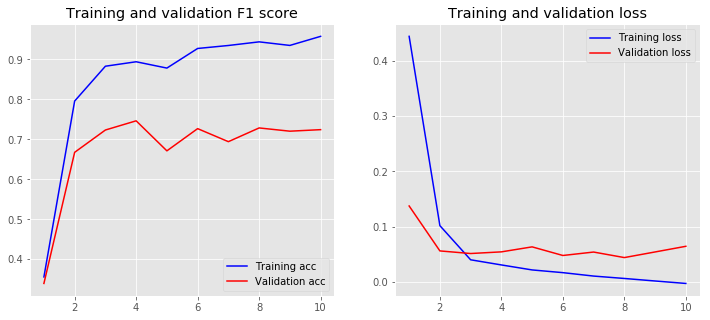

In [135]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [136]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

328
328/328 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           B       0.70      0.62      0.66       463
           I       0.56      0.49      0.52       243
           O       0.99      0.99      0.99     24878

    accuracy                           0.98     25584
   macro avg       0.75      0.70      0.72     25584
weighted avg       0.98      0.98      0.98     25584



## Fast Text

In [137]:
from gensim.models import KeyedVectors
from tqdm import tqdm

word_embedding_size = 150
embedding_dim = 300
# print("here")
# fasttext_path = "/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"  # Replace this with the path to your FastText model

# def load_fasttext_embeddings(fasttext_path, embedding_dim, word_index):
#     fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path, binary=False, encoding='utf-8')
#     print("Loading FastText embeddings...")
#     embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#     for word, i in tqdm(word_index.items()):
#         if word in fasttext_model:
#             embedding_matrix[i] = fasttext_model[word]

#     return embedding_matrix

# embedding_matrix = load_fasttext_embeddings(fasttext_path, embedding_dim, word2idx)

In [ ]:
import torch
from torchtext.vocab import FastText

# Load FastText embeddings
fasttext = FastText(language='en')

# Get the embedding dimension
embedding_dim = fasttext.dim

# Initialize the embedding matrix
embedding_matrix = torch.zeros((len(word2idx) + 1, embedding_dim))

# Populate the embedding matrix
for word, idx in tqdm(word2idx.items()):
    if word in fasttext.stoi:
        embedding_matrix[idx] = fasttext[word]

.vector_cache/wiki.en.vec:  16%|█▌        | 1.06G/6.60G [00:20<03:15, 28.4MB/s]   

In [ ]:
m = 78
# m = 76
input = Input(shape=(m,))
word_embedding_size = 100
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=300, input_length=m, weights=[embedding_matrix]))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.01)))

model.add(TimeDistributed(Dense(n_tags)))
# model.add(Activation('relu'))
crf_layer = CRF(n_tags)
model.add(crf_layer)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.05, beta_1=0.2, beta_2=0.1)

# # Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1,,callbacks=[f1_callback])

import joblib

# Assuming `model` is your Keras model
# Save the model
joblib.dump(model, "fasttext_ate_3.pkl")

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['f1_score_train']
    val_accuracy = history.history['f1_score_val']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation F1 score')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [ ]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
print(len(X_test))
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)